In [3]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [4]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [5]:
import os
key = os.environ.get('AZURE_SEARCH_KEY', '8f84cdb9458b401097518d069615779c')

### Test getting images url

In [6]:
results = search_images_bing(key, 'dior bag')
ims = results.attrgot('contentUrl')
len(ims)

150

### Test downloading an image

In [7]:
dest = "images/dior.jpg"
download_url(ims[0], dest)

Path('images/dior.jpg')

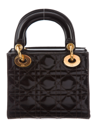

In [8]:
# Test displaying downloaded image
im = Image.open(dest)
im.to_thumb(128, 128)

### Download multiple images

In [19]:
brands = 'chanel','dior','gucci'
path = Path('bags')
path.exists()

True

In [20]:
if not path.exists():
    path.mkdir()
    for b in brands:
        dest = (path/b)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{b} bag')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [21]:
fns = get_image_files(path)
fns

(#344) [Path('bags/chanel/001ad971-cc42-44ab-bfc8-e42db73806dc.jpg'),Path('bags/chanel/0032e86f-2c74-49b2-b1b2-ded9efe03f4d.jpg'),Path('bags/chanel/053dfaf2-f2ba-4afc-b663-faa41e3c00de.jpg'),Path('bags/chanel/06b81834-e286-4e2c-89e9-dd1f66bdc01b.jpg'),Path('bags/chanel/07018941-bcd3-4f9b-b1ea-e705d859bb2a.jpg'),Path('bags/chanel/0cd3ed14-6b24-4c96-be9e-80f87f13dc17.jpg'),Path('bags/chanel/0db1935a-7297-4df4-82f8-8e792e192f94.JPG'),Path('bags/chanel/12dc0e18-8baa-4e03-a7c6-a8c2f534c4e2.jpg'),Path('bags/chanel/139232c1-c4d5-48bf-965f-9a761d250fd6.png'),Path('bags/chanel/164ea385-fa08-4972-ad5d-0af9e75b7aab.jpg')...]

In [22]:
failed = verify_images(fns)
failed

(#8) [Path('bags/chanel/bfedd143-047d-49ce-991f-ed6515d2f83f.jpg'),Path('bags/chanel/e590a030-31ad-4744-8ee2-0e2c66a91e48.jpg'),Path('bags/gucci/0b62497f-5314-4f37-96f9-3b29b31974d1.jpg'),Path('bags/gucci/2b0bfee3-42a9-4592-962b-922f963777f9.jpg'),Path('bags/gucci/3cf0017e-ead1-4d04-bd0f-d22697a30153.jpg'),Path('bags/gucci/4c191d4a-2b07-461e-9e54-eb8c01a1a693.jpg'),Path('bags/gucci/b0b55f24-294f-48e7-8e41-7ee0c225d96f.jpg'),Path('bags/gucci/f5e3f988-ee81-410e-8a82-563d5a352387.jpg')]

In [23]:
failed.map(Path.unlink)

(#8) [None,None,None,None,None,None,None,None]

### Create DataLoaders for training


In [24]:
# Define a DataBlock object
bags = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # (independent, dependent) aka (x, y)
    get_items=get_image_files, # tell fastai how to get images
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # split train and validate ds, seed=42 to keep same traning and validation set everytime
    get_y=parent_label,
    item_tfms=Resize(128) # how to transform each item in the ds
)

In [25]:
# tell fastai the source of data (the file path in this case)
dls = bags.dataloaders(path)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


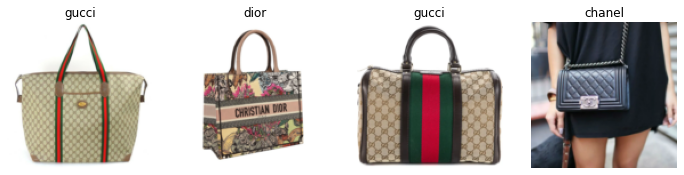

In [26]:
dls.valid.show_batch(max_n=4, nrows=1)

### Other images transformation functions

#### Squish / Stretch

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


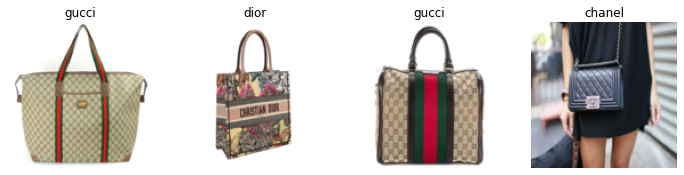

In [27]:
bags = bags.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bags.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

#### Pad the images

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


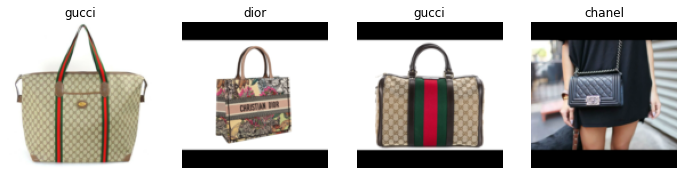

In [28]:
bags = bags.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bags.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

#### Random Resize Crop

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


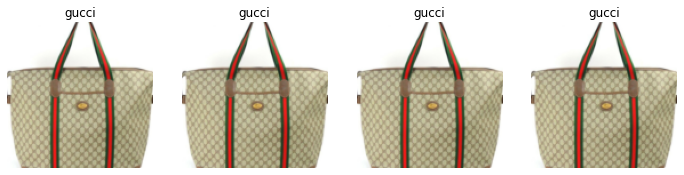

In [30]:
bags = bags.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bags.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1, unique=True)

### Data Augmentation
Creating random variations of our input data such that they appear different but do not change the meaning of the data

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


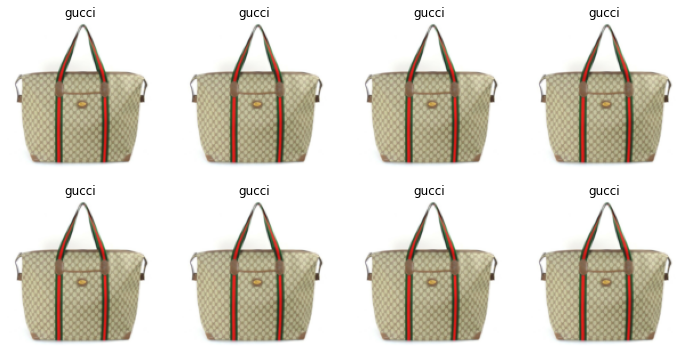

In [32]:
bags = bags.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bags.dataloaders(path)
dls.valid.show_batch(max_n=8, nrows=2, unique=True)

### Final Dataloader

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


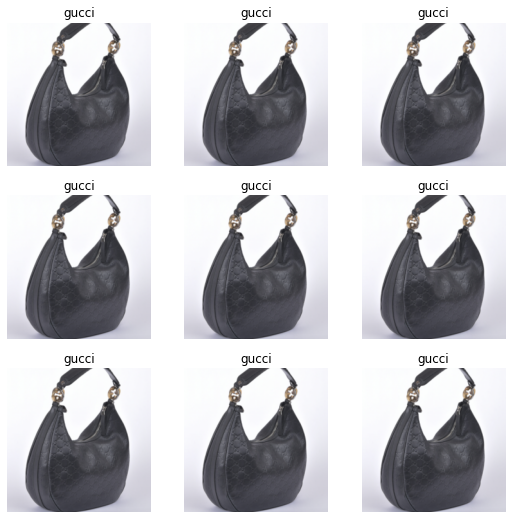

In [47]:
bags = bags.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5), 
    batch_tfms=aug_transforms())
dls = bags.dataloaders(path)
dls.valid.show_batch(unique=True)

Model: resnet 18
https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html

In [48]:
# Create a learner and fine-tune it
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.776573,2.250309,0.476923,00:54


epoch,train_loss,valid_loss,error_rate,time
0,1.033491,1.208352,0.461538,00:59
1,0.868743,0.643507,0.261538,01:04
2,0.734420,0.482828,0.246154,00:59
3,0.619050,0.441989,0.215385,01:04


### Confusion matrix

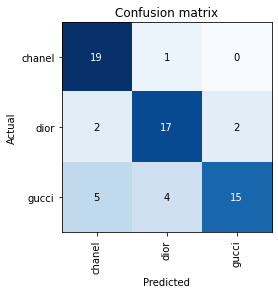

In [49]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

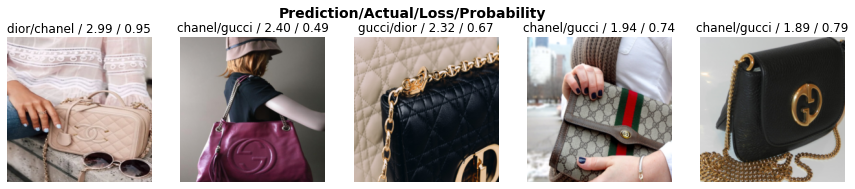

In [50]:
interp.plot_top_losses(5, nrows=1)

In [51]:
# Clean data
cleaner = ImageClassifierCleaner(learn)
cleaner

In [45]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

## Export

In [52]:
learn.export()

(#1) [Path('export.pkl')]

In [7]:
path = Path()
path.ls(file_exts='.pkl')
learn_inf = load_learner(path/'export.pkl')

In [20]:
pred,pred_idx,probs = learn_inf.predict('images/chanel2.jpg')
f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

'Prediction: chanel; Probability: 0.9125'

In [65]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value=(), description='Upload')

In [10]:
btn_upload = SimpleNamespace(data = ['images/gucci.jpg'])
img = PILImage.create(btn_upload.data[-1])

In [11]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [26]:
pred,pred_idx,probs = learn_inf.predict(img)

In [27]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: gucci; Probability: 0.8673')

In [28]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [29]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [30]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [31]:
#hide_output
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

## Deploy